# ML-Agents Q-Learning with GridWorld

Q-Learning 모델로 ML-Agents의 GridWorld 환경에서 학습  
[Q-Learning with a UnityEnvironment](https://colab.research.google.com/github/Unity-Technologies/ml-agents/blob/release_19_docs/colab/Colab_UnityEnvironment_2_Train.ipynb)을 클론 코딩함으로써 Unity ML-Agents python low level api와 Deep Reinforcement Learning (DRL)에 대한 실습을 진행함.


<img src="https://github.com/Unity-Technologies/ml-agents/blob/release_19_docs/docs/images/gridworld.png?raw=true" align="middle" width="435"/>

## Train the GridWorld Environment with Q-Learning

### What is the  GridWorld Environment

[GridWorld](https://github.com/Unity-Technologies/ml-agents/blob/release_19_docs/docs/Learning-Environment-Examples.md#gridworld) Environment는 간단한 Unity Visual environment이다. Agent는 파란색 사각형이며 3x3 grid내에서 red `x`를 피하면서 green `+`에 도달하는것을 목표로 한다.

observation은 image로 grid의 위에서 카메라에 의해 획득된다.

Action은 5개 중 하나이다.

* Do not move
* Move up
* Move down
* Move right
* Move left

Agent는 green `+`에 도달하면 1.0의 reward를 획득한다. red `x`에 도달 시 -1의 패널티를 획득한다. 또한 각 step마다 -0.01의 패널티가 부여된다.

> **Note** There are 9 Agents, each in their own grid, at once in the environment. This allows for faster data collection.

### The Q-Learning Algorithm

매우 간단한 Q-Learning 알고리즘으로 [pytorch](https://pytorch.org/)를 사용하였다.  

아래는 매우 간단한 신경망이다.

In [2]:
import torch
from typing import Tuple
from math import floor
from torch.nn import Parameter

class VisualQNetwork(torch.nn.Module):
    """image를 학습하는 매우 간단한 visual neural"""
    
    def __init__(self, input_shape: Tuple[int, int, int], encoding_size: int, output_size: int):
        """image batch (3 dimensional tensors)를 입력으로 사용하는 neural network를 생성한다.

        Args:
            input_shape (Tuple[int, int, int]): channel, height, width
            encoding_size (int): fully connected layer의 encoding size
            output_size (int): ouput size
        """
        
        super(VisualQNetwork, self).__init__()
        
        height = input_shape[1]
        width = input_shape[2]
        initial_channels = input_shape[0]
        conv_1_hw = self.conv_output_shape((height, width), 8, 4)
        conv_2_hw = self.conv_output_shape(conv_1_hw, 4, 2)
        
        self.final_flat = conv_2_hw[0] * conv_2_hw[1] * 32 # flatten된 conv2 ouput tensor의 size: height * width * out_channels
        self.conv1 = torch.nn.Conv2d(initial_channels, 16, [8, 8], [4, 4])
        self.conv2 = torch.nn.Conv2d(16, 32, [4, 4], [2, 2])
        self.dense1 = torch.nn.Linear(self.final_flat, encoding_size)
        self.dense2 = torch.nn.Linear(encoding_size, output_size)
        
    def forward(self, visual_obs: torch.Tensor):
        conv_1 = torch.relu(self.conv1(visual_obs))
        conv_2 = torch.relu(self.conv2(conv_1))
        hidden = self.dense1(conv_2.reshape([-1, self.final_flat])) # flatten and input to the fully connected layer
        hidden = torch.relu(hidden) # activation function
        hidden = self.dense2(hidden)
        return hidden
        
    
    @staticmethod
    def conv_output_shape(h_w: Tuple[int, int], kernel_size: int = 1, stride: int = 1, pad: int = 0, dilation: int = 1):
        """convolution layer의 출력의 height과 width를 반환한다."""
        
        h = floor(
            ((h_w[0] + (2 * pad) - (dilation * (kernel_size - 1)) - 1) / stride) + 1
        )
        w = floor(
            ((h_w[1] + (2 * pad) - (dilation * (kernel_size - 1)) - 1) / stride) + 1
        )
        return h, w
        

Q-Learning을 학습시키는데 사용할 data를 저장하기 위한 data type 정의. ReplayBuffer에 쓰임

In [3]:
import numpy as np
from typing import NamedTuple, List

class Experience(NamedTuple):
    """Agent transition data를 포함하는 experience"""
    
    obs: np.ndarray
    action: np.ndarray
    reward: float
    done: bool
    next_obs: np.ndarray
    
# A Trajectory is an ordered sequence of Experiences
Trajectory = List[Experience]

# A Buffer is an unordered list of Experiences from multiple Trajectories
Buffer = List[Experience]

trainer class를 정의함. trainer class는 policy를 따르는 environment로부터 data를 모은 뒤 Q-Network를 학습함.

In [4]:
from mlagents_envs.environment import ActionTuple, BaseEnv
from typing import Dict
import random

class Trainer:
    
    @staticmethod
    def generate_trajectories(env: BaseEnv, q_net: VisualQNetwork, buffer_size: int, epsilon: float):
        """Q-Network로부터 획득된 policy와 함께 주어진 Unity Environment를 실행해 획득된 experience들의 buffer를 생성한다.

        Args:
            env (BaseEnv): The UnityEnvironment used.
            q_net (VisualQNetwork): The Q-Network used to collect the data.
            buffer_size (int): The minimum size of the buffer this method will return.
            epsilon (float): Will add a random normal variable with standard deviation.
        
        Returns:
            a Tuple containing the created buffer and the average cumulative the Agents obtained.
        """
        
        buffer: Buffer = []
        
        # Reset the environment
        env.reset()
        # Environment의 Behavior Name을 저장함
        behavior_name = list(env.behavior_specs)[0]
        # Enviornment의 Behavior Specs를 저장함
        spec = env.behavior_specs[behavior_name]
        
        # AgentID에서 Trajectories로의 Mapping을 생성. 각 Agent에 대한 trajectories를 생성하기 위해서임.
        dict_trajectories_from_agent: Dict[int, Trajectory] = {}
        # AgentId에서 Agent의 last observation으로의 Mapping을 생성.
        dict_last_obs_from_agent: Dict[int, np.ndarray] = {}
        # AgentID에서 Agent의 last action으로의 Mapping을 생성.
        dict_last_action_from_agent: Dict[int, np.ndarray] = {}
        # AgentID에서 cumulative reward로의 Mapping을 생성.
        dict_cumulative_reward_from_agent: Dict[int, float] = {}
        # 지금까지 획득된 comulative reward를 저장하는 list 생성.
        cumulative_rewards: List[float] = []
        
        # buffer에 데이터가 충분해질때까지 반복
        while len(buffer) < buffer_size:
            # Agent의 Decision Step과 Terminal Step 획득
            decision_steps, terminal_steps = env.get_steps(behavior_name)
            
            # tensor를 NHWC에서 NCHW 형태로 변경. 즉, 이미지 tensor 채널을 PyTorch 입력에 맞게 변경함.
            order = (0, 3, 1, 2)
            decision_steps.obs[0] = np.transpose(decision_steps.obs[0], order)
            terminal_steps.obs[0] = np.transpose(terminal_steps.obs[0], order)
            
            # Terminal Step을 가진 모든 Agent에 대해 반복
            for agent_id_terminated in terminal_steps:
                # Agent가 terminated됬기 때문에 last experience를 생성
                last_experience = Experience(
                    obs=dict_last_obs_from_agent[agent_id_terminated].copy(),
                    reward=terminal_steps[agent_id_terminated].reward,
                    done=not terminal_steps[agent_id_terminated].interrupted,
                    action=dict_last_action_from_agent[agent_id_terminated].copy(),
                    next_obs=terminal_steps[agent_id_terminated].obs[0]
                )
                
                # trajectory가 끝났기 때문에 agent의 last observation과 action을 제거함
                dict_last_obs_from_agent.pop(agent_id_terminated)
                dict_last_action_from_agent.pop(agent_id_terminated)
                # cumulative reward를 기록함
                cumulative_reward = dict_cumulative_reward_from_agent.pop(agent_id_terminated) + terminal_steps[agent_id_terminated].reward
                cumulative_rewards.append(cumulative_reward)
                # Trajectory와 last experience를 buffer에 추가
                buffer.extend(dict_trajectories_from_agent.pop(agent_id_terminated))
                buffer.append(last_experience)
            
            # Decision Step을 가진 모든 Agent에 대해
            for agent_id_decisions in decision_steps:
                # Agent가 Trajectory가 없다면 생성
                if agent_id_decisions not in dict_trajectories_from_agent:
                    dict_trajectories_from_agent[agent_id_decisions] = []
                    dict_cumulative_reward_from_agent[agent_id_decisions] = 0
                    
                # decision을 요청하는 Agent가 "last observation"을 가지고 있다면
                if agent_id_decisions in dict_last_obs_from_agent:
                    # last observation으로부터의 Experience와 Decision Step을 생성
                    exp = Experience(
                        obs=dict_last_obs_from_agent[agent_id_decisions].copy(),
                        reward=decision_steps[agent_id_decisions].reward,
                        done=False,
                        action=dict_last_action_from_agent[agent_id_decisions].copy(),
                        next_obs=decision_steps[agent_id_decisions].obs[0]
                    )
                    # Agent의 Trajectory와 cumulative reward를 Update
                    dict_trajectories_from_agent[agent_id_decisions].append(exp)
                    dict_cumulative_reward_from_agent[agent_id_decisions] += decision_steps[agent_id_decisions].reward
                    
                # 새로운 "last observation"을 저장함
                dict_last_obs_from_agent[agent_id_decisions] = decision_steps[agent_id_decisions].obs[0]
                
            # decision을 요청한 모든 Agent에 대한 action을 생성
            # observation에 대한 각 action value를 계산
            actions_values = q_net(torch.from_numpy(decision_steps.obs[0])).detach().numpy()
            # noise 추가
            actions_values += epsilon * np.random.randn(actions_values.shape[0], actions_values.shape[1]).astype(np.float32)
            # best action 선택
            actions = np.argmax(actions_values, axis=1)
            actions.resize((len(decision_steps), 1))
            # 선택된 action들을 저장
            for agent_index, agent_id in enumerate(decision_steps.agent_id):
                dict_last_action_from_agent[agent_id] = actions[agent_index]
            
            # environment 내 action들을 설정
            # Unity Environments는 ActionTuple instance를 사용함
            action_tuple = ActionTuple()
            action_tuple.add_discrete(actions)
            env.set_actions(behavior_name, action_tuple)
            # 다음 step으로 진행
            env.step()
        return buffer, np.mean(cumulative_rewards)
    
    @staticmethod
    def update_q_net(q_net: VisualQNetwork, optimizer: torch.optim, buffer: Buffer, action_size: int):
        """제공된 optimizer와 buffer로 Q-Network를 update함."""
        
        BATCH_SIZE = 1000
        NUM_EPOCH = 3
        GAMMA = 0.9
        
        batch_size = min(len(buffer), BATCH_SIZE)
        random.shuffle(buffer)
        # buffer를 batch size 단위로 split함.
        batches = [buffer[batch_size * start : batch_size * (start + 1)] for start in range(int(len(buffer) / batch_size))]
        
        for _ in range(NUM_EPOCH):
            for batch in batches:
                # network에 입력될 Tensor를 생성
                obs = torch.from_numpy(np.stack([ex.obs for ex in batch]))
                reward = torch.from_numpy(np.array([ex.reward for ex in batch], dtype=np.float32).reshape(-1, 1))
                done = torch.from_numpy(np.array([ex.done for ex in batch], dtype=np.float32).reshape(-1, 1))
                action = torch.from_numpy(np.stack([ex.action for ex in batch]))
                next_obs = torch.from_numpy(np.stack(ex.next_obs for ex in batch))
                
                # Q-Network를 update하기 위해 Bellman equation 사용
                target = reward + (1.0 - done) * GAMMA * torch.max(q_net(next_obs).detach(), dim=1, keepdim=True).values
                mask = torch.zeros((len(batch), action_size))
                mask.scatter_(1, action, 1)
                prediction = torch.sum(q_net(obs) * mask, dim=1, keepdim=True)
                criterion = torch.nn.MSELoss()
                loss = criterion(prediction, target)
                
                # backpropagation 실행
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

### Run Training

GridWorld environment created.


c:\anaconda3\envs\ml-agents-release19\lib\site-packages\IPython\core\interactiveshell.py:3457: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Training step: 1 	reward: -0.7788888714793656
Training step: 2 	reward: -0.999999980131785
Training step: 3 	reward: -0.9999999776482582
Training step: 4 	reward: -0.800999984331429
Training step: 5 	reward: -0.999999980131785
Training step: 6 	reward: -0.7788888689958386
Training step: 7 	reward: -0.9999999776482582
Training step: 8 	reward: -1.0022222023043368
Training step: 9 	reward: -0.7844444269107448
Training step: 10 	reward: -0.5633333182583252


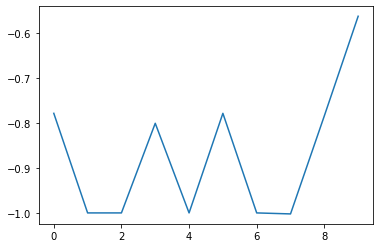

In [5]:
# -----------------
# Unity Environment가 닫혀있지 않았을 경우를 위한 처리
try:
    env.close()
except:
    pass
# -----------------

from mlagents_envs.registry import default_registry
from mlagents_envs.environment import UnityEnvironment
import matplotlib.pyplot as plt
import os
%matplotlib inline

# CridWorl Environment 생성

env_name = "GridWorld"
env_path = f"{os.pardir}/Environments/{env_name}"
env = UnityEnvironment(env_path)
print("GridWorld environment created.")

num_actions = 5
learning_rate = 0.001

try:
    # Q-Network 생성
    qnet = VisualQNetwork((3, 64, 84), 126, num_actions)
    
    experiences: Buffer = []
    optim = torch.optim.Adam(qnet.parameters(), lr=learning_rate)
    
    cumulatvie_rewards: List[float] = []
    
    NUM_TRAINING_STEPS = 10 # The number of training steps that will be performed
    NUM_NEW_EXP = 1000 # The number of experiences to collect per training step
    BUFFER_SIZE = 10000 # The maximum size of the Buffer
    
    for n in range(NUM_TRAINING_STEPS):
        new_exp, _ = Trainer.generate_trajectories(env, qnet, NUM_NEW_EXP, epsilon=0.1)
        
        if len(experiences) > BUFFER_SIZE:
            experiences = experiences[:BUFFER_SIZE]
        experiences.extend(new_exp)
        Trainer.update_q_net(qnet, optim, experiences, num_actions)
        _, rewards = Trainer.generate_trajectories(env, qnet, 100, epsilon=0)
        cumulatvie_rewards.append(rewards)
        print(f"Training step: {n + 1} \treward: {rewards}")
except KeyboardInterrupt:
    print("\nTraining interrupted, continue to next cell to save to save the model.")
finally:
    env.close()
    plt.plot(cumulatvie_rewards)

### Export PyTorch Model to ONNX

Unity ML-Agents의 inference에 사용할 model을 추출한다. 이를 위해 다음과 같은 추가적인 tensor가 필요하다.

* All models need version_number
* All models need memory_size
* Models with **continuous outputs** need continuous_action_output_shape
* Models with **discrete outputs** need discrete_action_output_shape and an additional mask input that matches the shape of the discrete outputs
* The mask input must be connected to the outputs or it will be pruned on export, if mask values aren't being set they will be 1, so multiplying the discrete outputs by the mask will have no effect

In [6]:
class WrapperNet(torch.nn.Module):
    
    def __init__(self, qnet: VisualQNetwork, discrete_ouput_sizes: List[int]):
        """
        runtime inference에 의해 요구되는 여분의 상수들과 
        더미 mask input들을 추가한 VisualQNetwork를 Wraping한다.
        """
        
        super(WrapperNet, self).__init__()
        self.qnet = qnet
        
        # version_number
        #   MLAgents1_0 = 2
        #   MLAgents2_0 = 3
        version_number = torch.Tensor([3])
        self.version_number = Parameter(version_number, requires_grad=False)
        
        # memory_size
        # TODO: document case where memory is not zero.
        memory_size = torch.Tensor([0])
        self.memory_size = Parameter(memory_size, requires_grad=False)
        
        # discrete_action_ouput_shape
        output_shape = torch.Tensor([discrete_ouput_sizes])
        self.discrete_shape = Parameter(output_shape, requires_grad=False)
        
    # discrete action이라면 input으로 같은 shape의 mask tensor를 받는다.
    def forward(self, visual_obs: torch.Tensor, mask: torch.Tensor):
        qnet_result = self.qnet(visual_obs)
        # 제거되는 현상을 막기 위해 mask를 연결
        # WriteDiscreteActionMask() 내에서 SetActionMask()를 호출하지 않을 경우 mask value는 1
        qnet_result = torch.mul(qnet_result, mask)
        action = torch.argmax(qnet_result, dim=1, keepdim=True)
        return [action], self.discrete_shape, self.version_number, self.memory_size

In [7]:
from devslem.utility import create_dir, add_datetime_suffix

dir = f"{os.pardir}/results/{env_name}/"
file_name = add_datetime_suffix(env_name)

create_dir(dir)
    
torch.onnx.export(
    WrapperNet(qnet, [num_actions]),
    (torch.tensor([experiences[0].obs]), torch.ones(1, num_actions)),
    f"{dir}{file_name}",
    opset_version=9,
    input_names=["obs_0", "action_masks"],
    output_names=["discrete_actions", "discrete_action_ouput_shape", "version_number", "memory_size"],
    dynamic_axes={
        "obs_0": {0: "batch"},
        "action_masks": {0: "batch"},
        "discrete_actions": {0: "batch"},
        "discrete_action_ouput_shape": {0: "batch"}
    }
)

c:\anaconda3\envs\ml-agents-release19\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:210.)
  # Remove the CWD from sys.path while we load stuff.


## References

[1] [Q-Learning with a UnityEnvironment](https://colab.research.google.com/github/Unity-Technologies/ml-agents/blob/release_19_docs/colab/Colab_UnityEnvironment_2_Train.ipynb)